## **Method of Label-dependent Costs**

*This method adjusts the cost (or weight) of different types of errors in the loss function to account for label noise.*

Weighted Logistic Regression - Mean accuracy: 0.8123, Standard deviation: 0.0793
Unweighted Logistic Regression - Mean accuracy: 0.7717, Standard deviation: 0.0801
SVM - Mean accuracy: 0.8946, Standard deviation: 0.0547


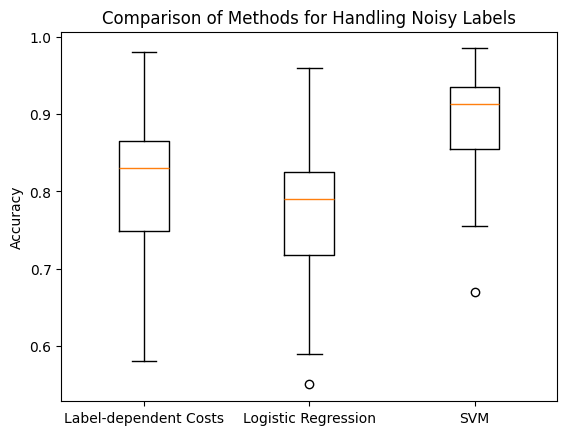

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=10, n_samples=1000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=10, n_samples=2000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=10, n_samples=3000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=20, n_samples=1000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=20, n_samples=2000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=20, n_samples=3000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=30, n_samples=1000
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=30, n_

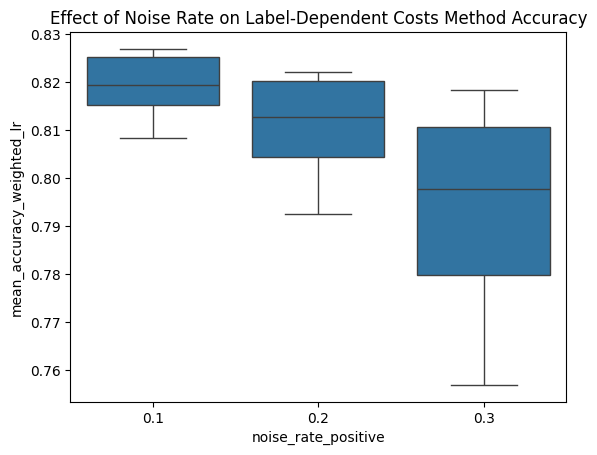

In [4]:
# Multiple Configurations for Label-Dependent Costs
def simulation_study_multiple_configs_label_dependent_costs(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, seed=None):
    results = []

    for noise_rate_positive, noise_rate_negative in zip(noise_rate_positives, noise_rate_negatives):
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate_positive=noise_rate_positive,
                    noise_rate_negative=noise_rate_negative,
                    test_size=test_size,
                    seed=seed
                )
                print("Simulation run successful.")

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate_positive': noise_rate_positive,
                    'noise_rate_negative': noise_rate_negative,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results

# Example usage:
noise_rate_positives = [0.1, 0.2, 0.3]
noise_rate_negatives = [0.1, 0.2, 0.3]
n_features_list = [10, 20, 30]
n_samples_list = [1000, 2000, 3000]

results_label_dependent_costs = simulation_study_multiple_configs_label_dependent_costs(
    noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, seed=42
)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results_label_dependent_costs = pd.DataFrame(results_label_dependent_costs)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate_positive', y='mean_accuracy_weighted_lr', data=df_results_label_dependent_costs)
plt.title("Effect of Noise Rate on Label-Dependent Costs Method Accuracy")
plt.show()

#### UCI Benchmark Dataset

Weighted Logistic Regression - Mean accuracy: 0.9446, Standard deviation: 0.0261
Unweighted Logistic Regression - Mean accuracy: 0.8881, Standard deviation: 0.0327
SVM - Mean accuracy: 0.9336, Standard deviation: 0.0235


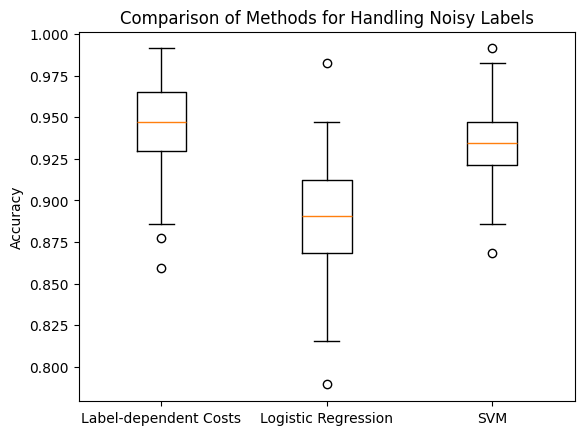

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI Breast Cancer dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate_positive, noise_rate_negative, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)